In [2]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
from keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
import time
import matplotlib.pyplot as plt

**Open csv and merge both df**

In [3]:
data=pd.read_csv("../../UCSD-Microgrid-Database\Data Files\BuildingLoadWithEV\HopkinsBuilding.csv")

data=pd.DataFrame(data)

data["DateTime"]=pd.to_datetime(data["DateTime"])

data

DateTime  RealPower
0     2020-01-01 00:00:00     38.456
1     2019-12-31 23:45:00     38.394
2     2019-12-31 23:30:00     38.619
3     2019-12-31 23:15:00     38.577
4     2019-12-31 23:00:00     38.493
...                   ...        ...
26396 2019-04-01 01:00:00     51.912
26397 2019-04-01 00:45:00     50.980
26398 2019-04-01 00:30:00     51.873
26399 2019-04-01 00:15:00     51.186
26400 2019-04-01 00:00:00     50.676

[26401 rows x 2 columns]

In [4]:
data2=pd.read_csv("../../UCSD-Microgrid-Database\Data Files\BuildingLoadWithEV\HopkinsEV.csv")

data2=pd.DataFrame(data2)

data2["DateTime"]=pd.to_datetime(data2["DateTime"])

data2=data2.rename(columns={"RealPower":"EV_Power"})

data2

DateTime  EV_Power
0     2020-01-01 00:00:00       0.0
1     2019-12-31 23:45:00       0.0
2     2019-12-31 23:30:00       0.0
3     2019-12-31 23:15:00       0.0
4     2019-12-31 23:00:00       0.0
...                   ...       ...
26396 2019-04-01 01:00:00       0.0
26397 2019-04-01 00:45:00       0.0
26398 2019-04-01 00:30:00       0.0
26399 2019-04-01 00:15:00       0.0
26400 2019-04-01 00:00:00       0.0

[26401 rows x 2 columns]

In [5]:
df=pd.merge(data,data2, on="DateTime", how="outer")
df

DateTime  RealPower  EV_Power
0     2020-01-01 00:00:00     38.456       0.0
1     2019-12-31 23:45:00     38.394       0.0
2     2019-12-31 23:30:00     38.619       0.0
3     2019-12-31 23:15:00     38.577       0.0
4     2019-12-31 23:00:00     38.493       0.0
...                   ...        ...       ...
26396 2019-04-01 01:00:00     51.912       0.0
26397 2019-04-01 00:45:00     50.980       0.0
26398 2019-04-01 00:30:00     51.873       0.0
26399 2019-04-01 00:15:00     51.186       0.0
26400 2019-04-01 00:00:00     50.676       0.0

[26401 rows x 3 columns]

*Reverse the order of data*

In [6]:
df = df[::-1]
df

DateTime  RealPower  EV_Power
26400 2019-04-01 00:00:00     50.676       0.0
26399 2019-04-01 00:15:00     51.186       0.0
26398 2019-04-01 00:30:00     51.873       0.0
26397 2019-04-01 00:45:00     50.980       0.0
26396 2019-04-01 01:00:00     51.912       0.0
...                   ...        ...       ...
4     2019-12-31 23:00:00     38.493       0.0
3     2019-12-31 23:15:00     38.577       0.0
2     2019-12-31 23:30:00     38.619       0.0
1     2019-12-31 23:45:00     38.394       0.0
0     2020-01-01 00:00:00     38.456       0.0

[26401 rows x 3 columns]

**Convert Datetime in Timestamp**

In [7]:
df['Timestamp'] = df['DateTime'].astype('int64')

df

C:\Users\giuliana\AppData\Local\Temp\ipykernel_15708\1428981273.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Timestamp'] = df['DateTime'].astype('int64')


DateTime  RealPower  EV_Power            Timestamp
26400 2019-04-01 00:00:00     50.676       0.0  1554076800000000000
26399 2019-04-01 00:15:00     51.186       0.0  1554077700000000000
26398 2019-04-01 00:30:00     51.873       0.0  1554078600000000000
26397 2019-04-01 00:45:00     50.980       0.0  1554079500000000000
26396 2019-04-01 01:00:00     51.912       0.0  1554080400000000000
...                   ...        ...       ...                  ...
4     2019-12-31 23:00:00     38.493       0.0  1577833200000000000
3     2019-12-31 23:15:00     38.577       0.0  1577834100000000000
2     2019-12-31 23:30:00     38.619       0.0  1577835000000000000
1     2019-12-31 23:45:00     38.394       0.0  1577835900000000000
0     2020-01-01 00:00:00     38.456       0.0  1577836800000000000

[26401 rows x 4 columns]

In [27]:
df.to_csv("raw_data.csv")

*Dispersion of Real Power and EV Power respect Date*

In [8]:
df.describe()

DateTime     RealPower      EV_Power     Timestamp
count                26401  26401.000000  26401.000000  2.640100e+04
mean   2019-08-16 12:00:00     48.326141      6.179136  1.565957e+18
min    2019-04-01 00:00:00     -1.161000     -6.400000  1.554077e+18
25%    2019-06-08 18:00:00     45.908000      0.000000  1.560017e+18
50%    2019-08-16 12:00:00     48.338000      0.000000  1.565957e+18
75%    2019-10-24 06:00:00     51.793000      9.500000  1.571897e+18
max    2020-01-01 00:00:00     82.339000     55.150000  1.577837e+18
std                    NaN      5.720169      9.104970  6.859311e+15

C:\Users\giuliana\AppData\Local\Temp\ipykernel_15708\277175134.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["DateTime"]=pd.to_datetime(df["DateTime"])


<function matplotlib.pyplot.show(close=None, block=None)>

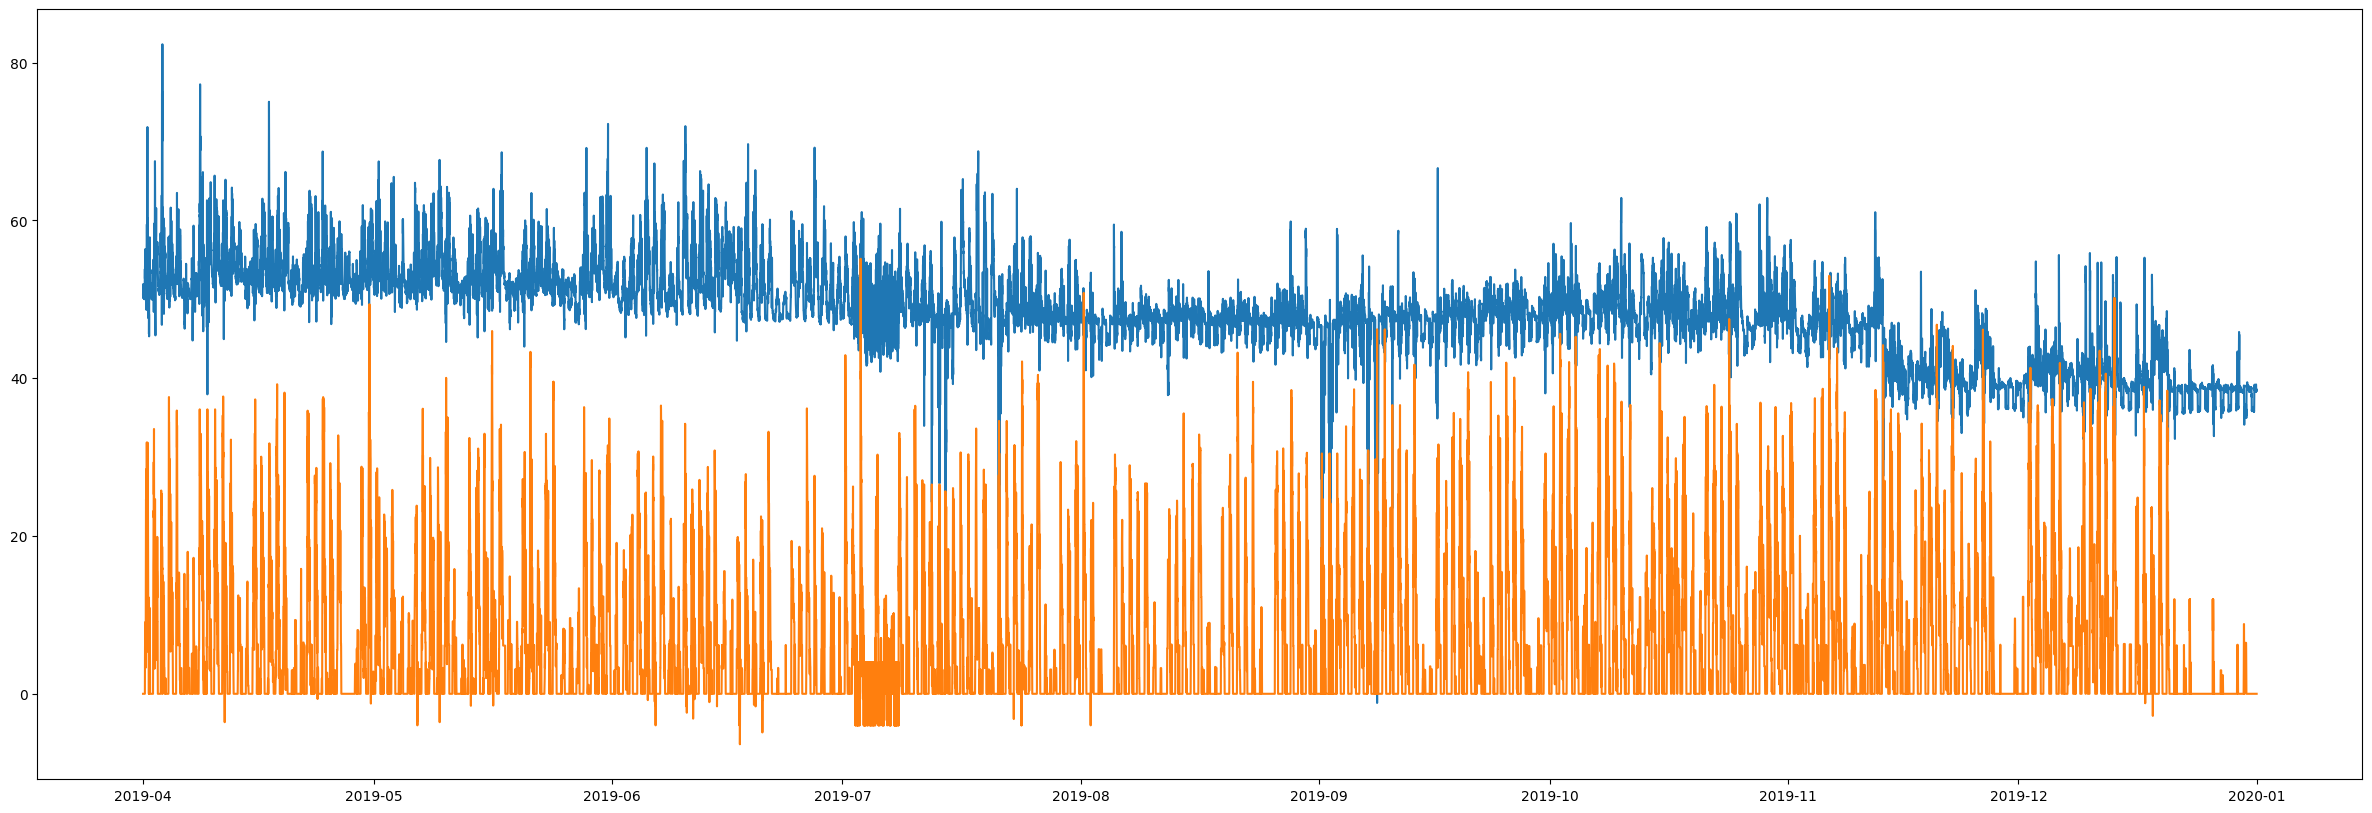

In [9]:
df["DateTime"]=pd.to_datetime(df["DateTime"])

plt.figure(figsize=(30,10))
plt.plot(df["DateTime"], df["RealPower"])
plt.plot(df["DateTime"], df["EV_Power"])
plt.show

**LSTM: Separation of data (training and testing)**

In [10]:
total_rows = df.shape[0]

training_porcentage = 0.8

#Number of rows in training data

training_rows = int(total_rows * training_porcentage)
testing_rows = total_rows - training_rows

#separation of training and testing

X_train = df[["Timestamp", "EV_Power","DateTime"]][:training_rows]
Y_train = df[["RealPower"]][:training_rows]

X_test = df[["Timestamp", "EV_Power", "DateTime"]][training_rows:]
Y_test = df[["RealPower"]][training_rows:]

print('Train set:', X_train.shape, Y_train.shape)
print('Test set:', X_test.shape, Y_test.shape)


Train set: (21120, 3) (21120, 1)
Test set: (5281, 3) (5281, 1)


**LSTM: Standardization of Training data (-1,1)**

In [11]:
s1=MinMaxScaler(feature_range=(-1,1))
Xs=s1.fit_transform(X_train[["Timestamp", "EV_Power"]])

s2=MinMaxScaler(feature_range=(-1,1))
Ys=s2.fit_transform(Y_train[["RealPower"]])

**LSTM: window**

In [12]:
window=96
X=[]
Y=[]
for i in range(window, len(Xs)):
    X.append(Xs[i-window:i,:])
    Y.append(Ys[i])
X,Y=np.array(X), np.array(Y)

**LSTM:Model**

In [13]:
model=Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(X.shape[1], 2)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))

model.add(Dense(units=1))

model.compile(optimizer="adam", loss="mean_squared_error",
              metrics=["accuracy"])

t0=time.time()

es=EarlyStopping(monitor="loss", mode="min",
                 verbose=1, patience=10)

t0=time.time()

history=model.fit(X,Y,epochs=10,batch_size=250,
                  callbacks=[es], verbose=1)

t1=time.time()

print("Runtime:%.2f s" % (t1-t0))

Epoch 1/10
85/85 [==============================] - 52s 512ms/step - loss: 0.0106 - accuracy: 0.0000e+00
Epoch 2/10
85/85 [==============================] - 43s 506ms/step - loss: 0.0073 - accuracy: 0.0000e+00
Epoch 3/10
85/85 [==============================] - 42s 494ms/step - loss: 0.0069 - accuracy: 0.0000e+00
Epoch 4/10
85/85 [==============================] - 42s 498ms/step - loss: 0.0067 - accuracy: 0.0000e+00
Epoch 5/10
85/85 [==============================] - 42s 495ms/step - loss: 0.0066 - accuracy: 0.0000e+00
Epoch 6/10
85/85 [==============================] - 42s 499ms/step - loss: 0.0065 - accuracy: 0.0000e+00
Epoch 7/10
85/85 [==============================] - 42s 494ms/step - loss: 0.0064 - accuracy: 0.0000e+00
Epoch 8/10
85/85 [==============================] - 42s 499ms/step - loss: 0.0063 - accuracy: 0.0000e+00
Epoch 9/10
85/85 [==============================] - 42s 498ms/step - loss: 0.0063 - accuracy: 0.0000e+00
Epoch 10/10
85/85 [==============================] - 47

*Plot loss*

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


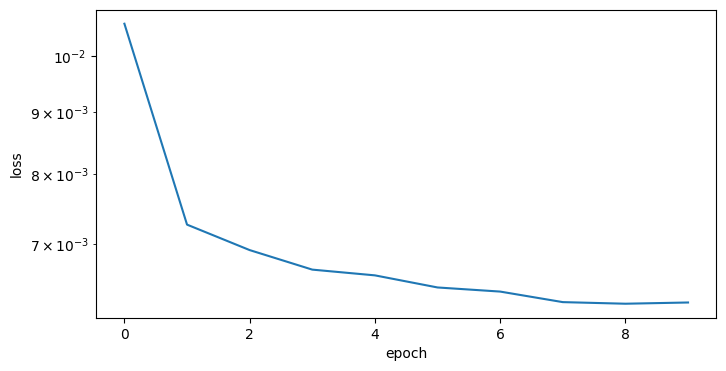

In [14]:
plt.figure(figsize=(8,4))
plt.semilogy(history.history["loss"])
plt.xlabel("epoch")
plt.ylabel("loss")
model.save("model")

**LSTM: verification of fit model**

In [15]:
Yp=model.predict(X)

Yu=s2.inverse_transform(Yp)
Ym=s2.inverse_transform(Y)

657/657 [==============================] - 31s 45ms/step


*Plot of mesuared value between lstm model*

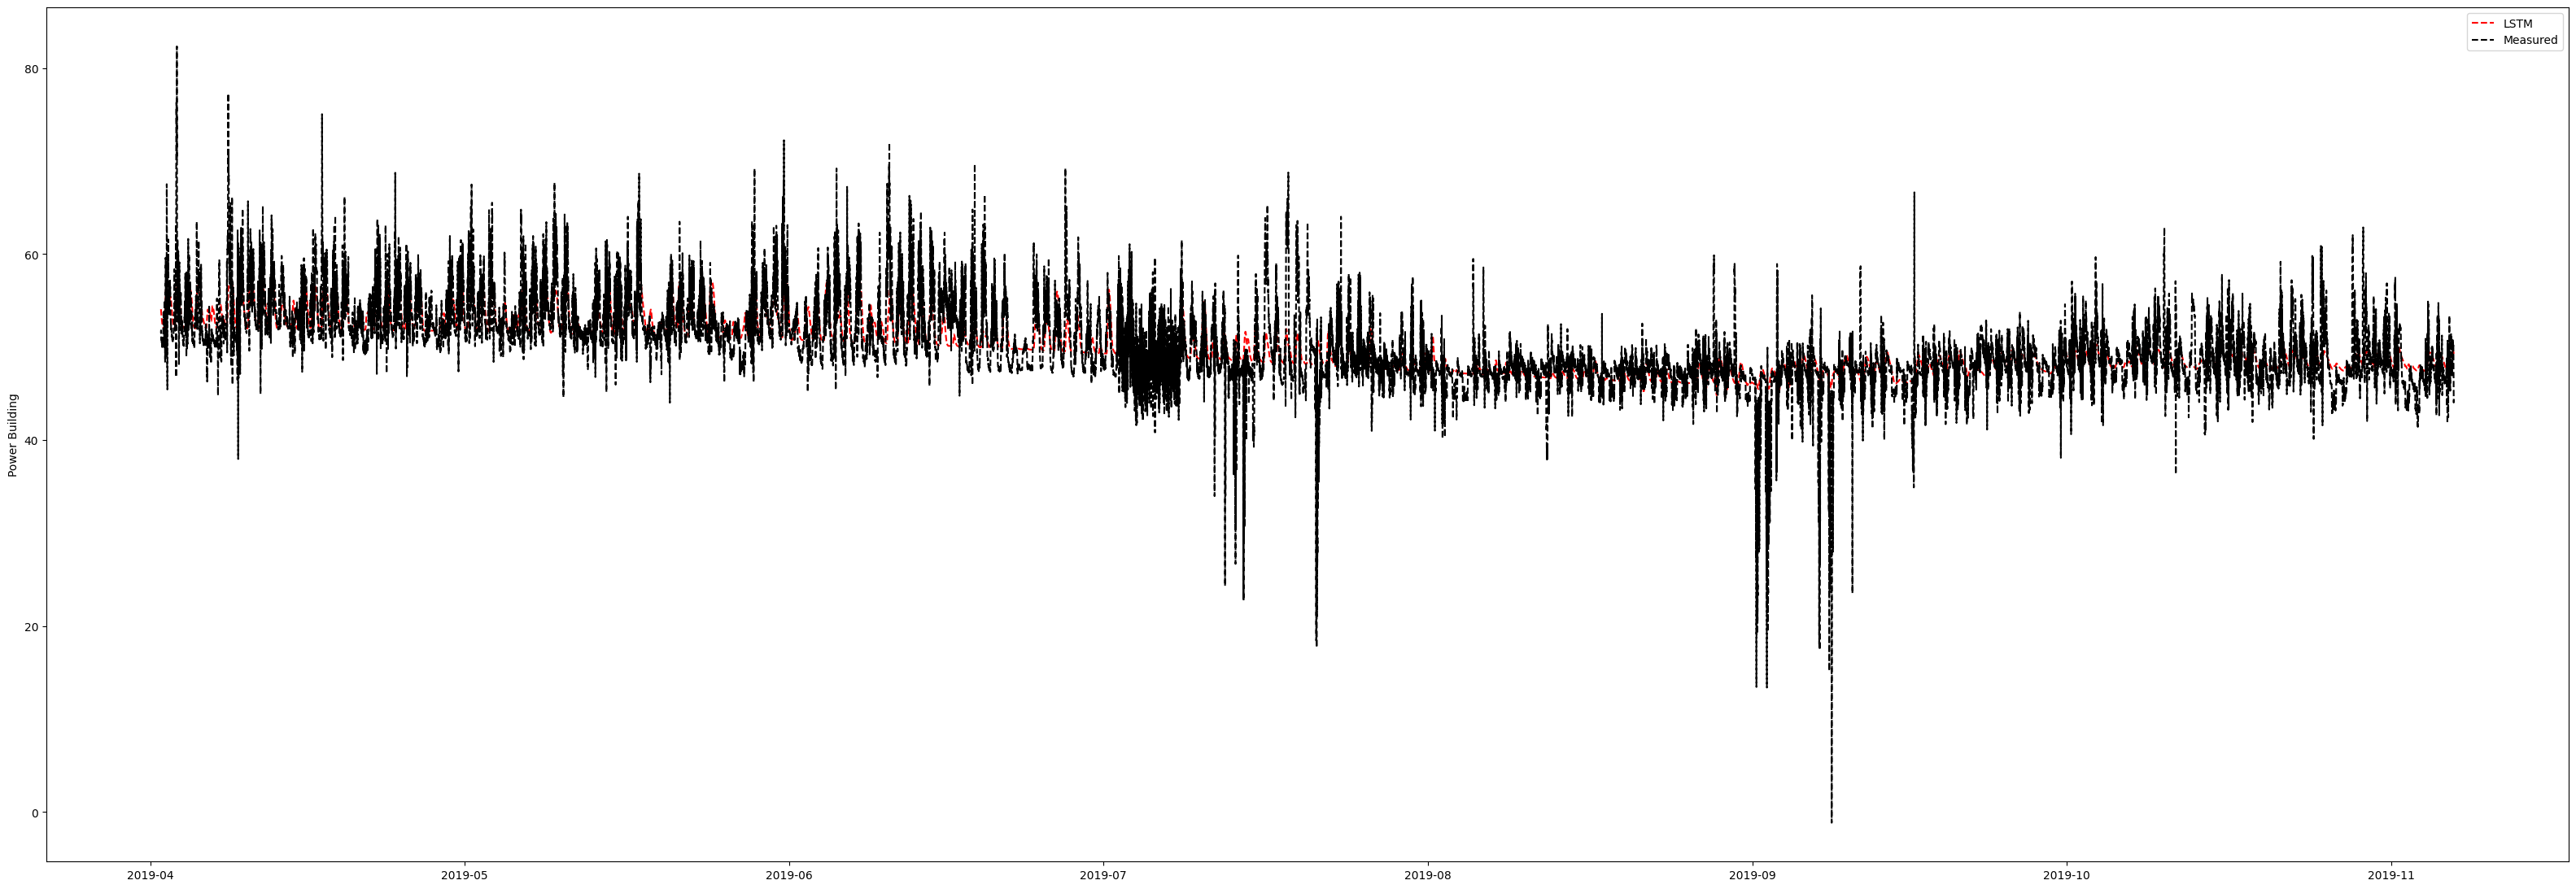

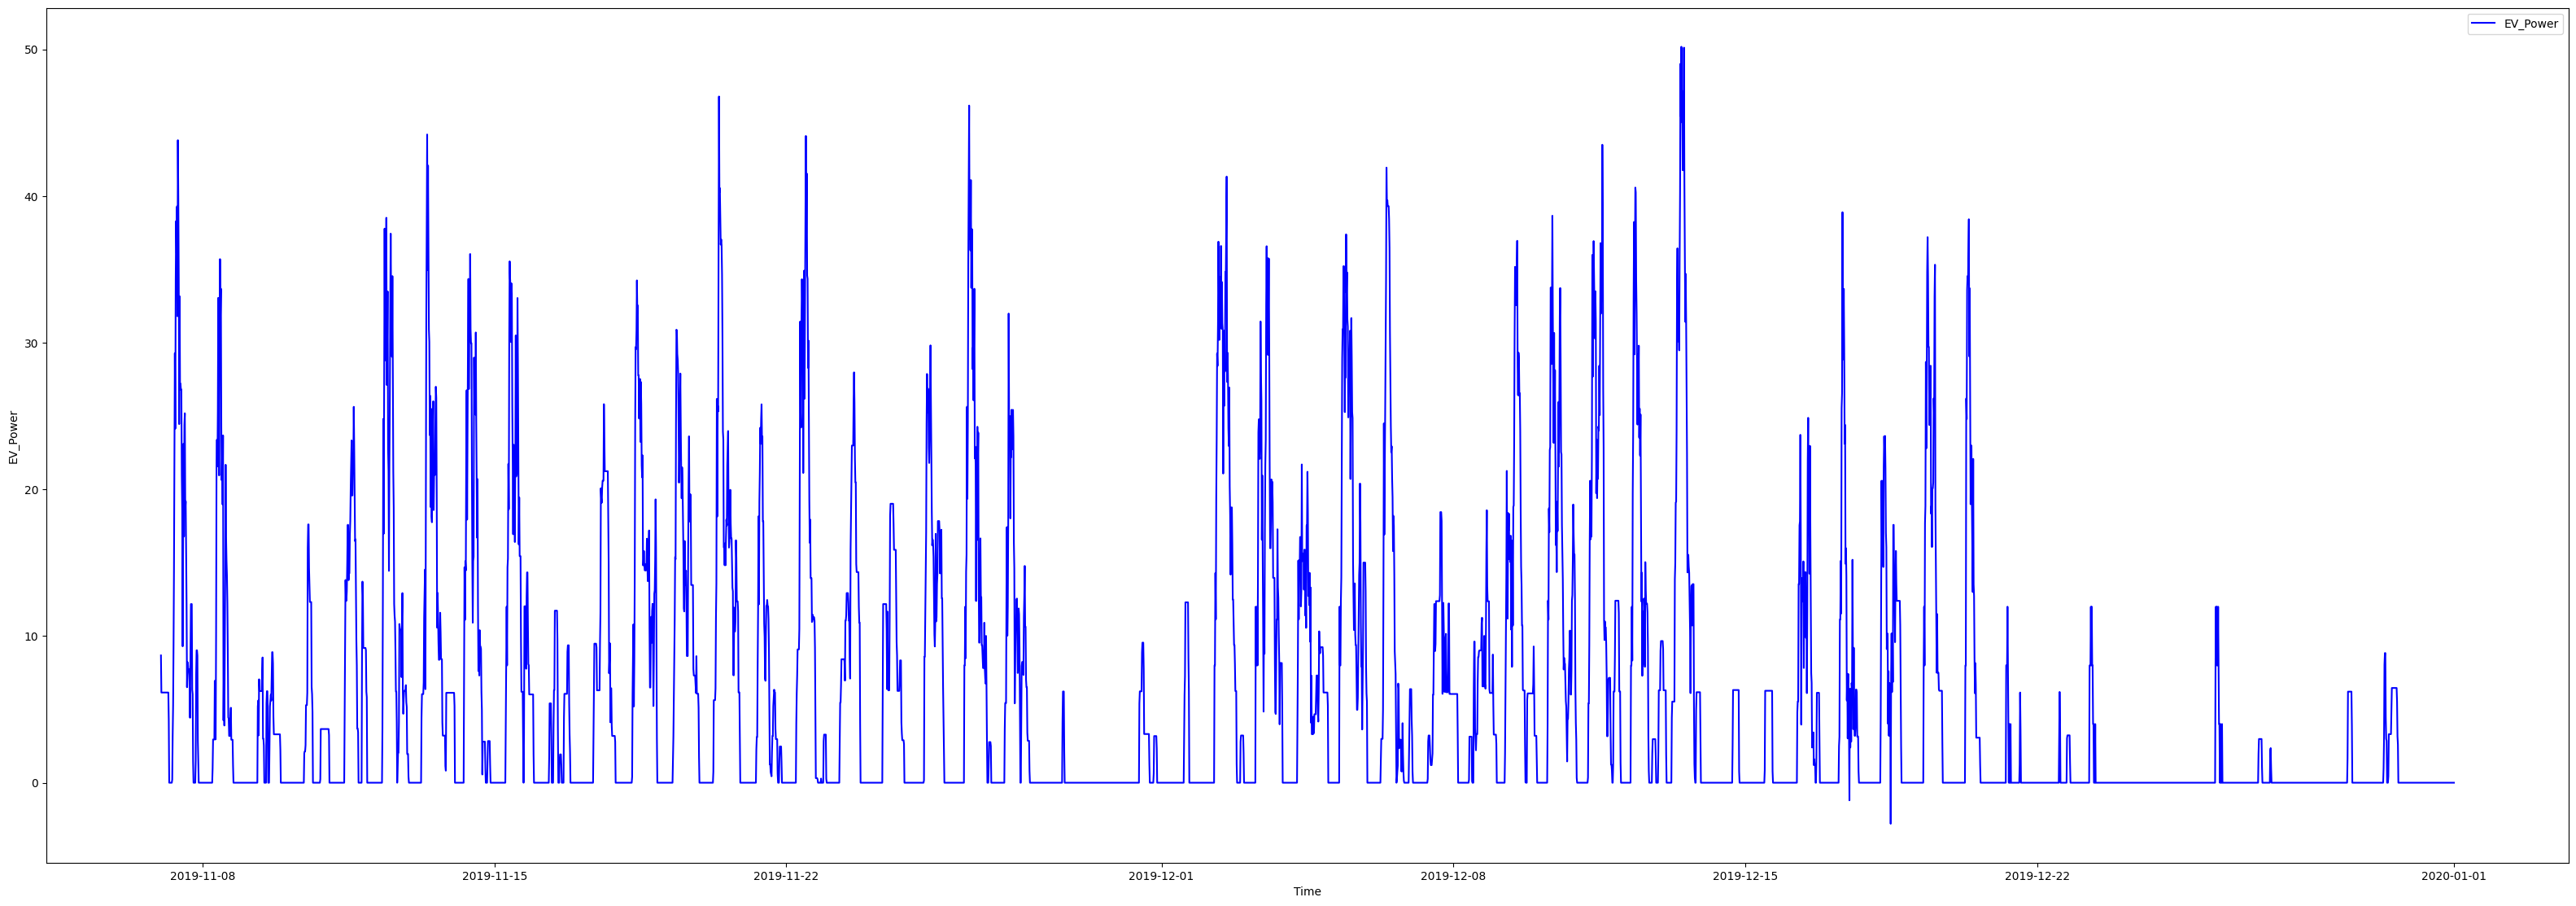

In [16]:
plt.figure(figsize=(40,30))
plt.subplot(2,1,1)
plt.plot(X_train["DateTime"][window:], Yu, "r--", label="LSTM")
plt.plot(X_train["DateTime"][window:], Ym, "k--", label="Measured")
plt.ylabel("Power Building")
plt.legend()


plt.figure(figsize=(40,30))
plt.subplot(2,1,1)
plt.plot(X_test["DateTime"], X_test["EV_Power"],"b-", label="EV_Power")
plt.xlabel("Time")
plt.ylabel("EV_Power")
plt.legend()

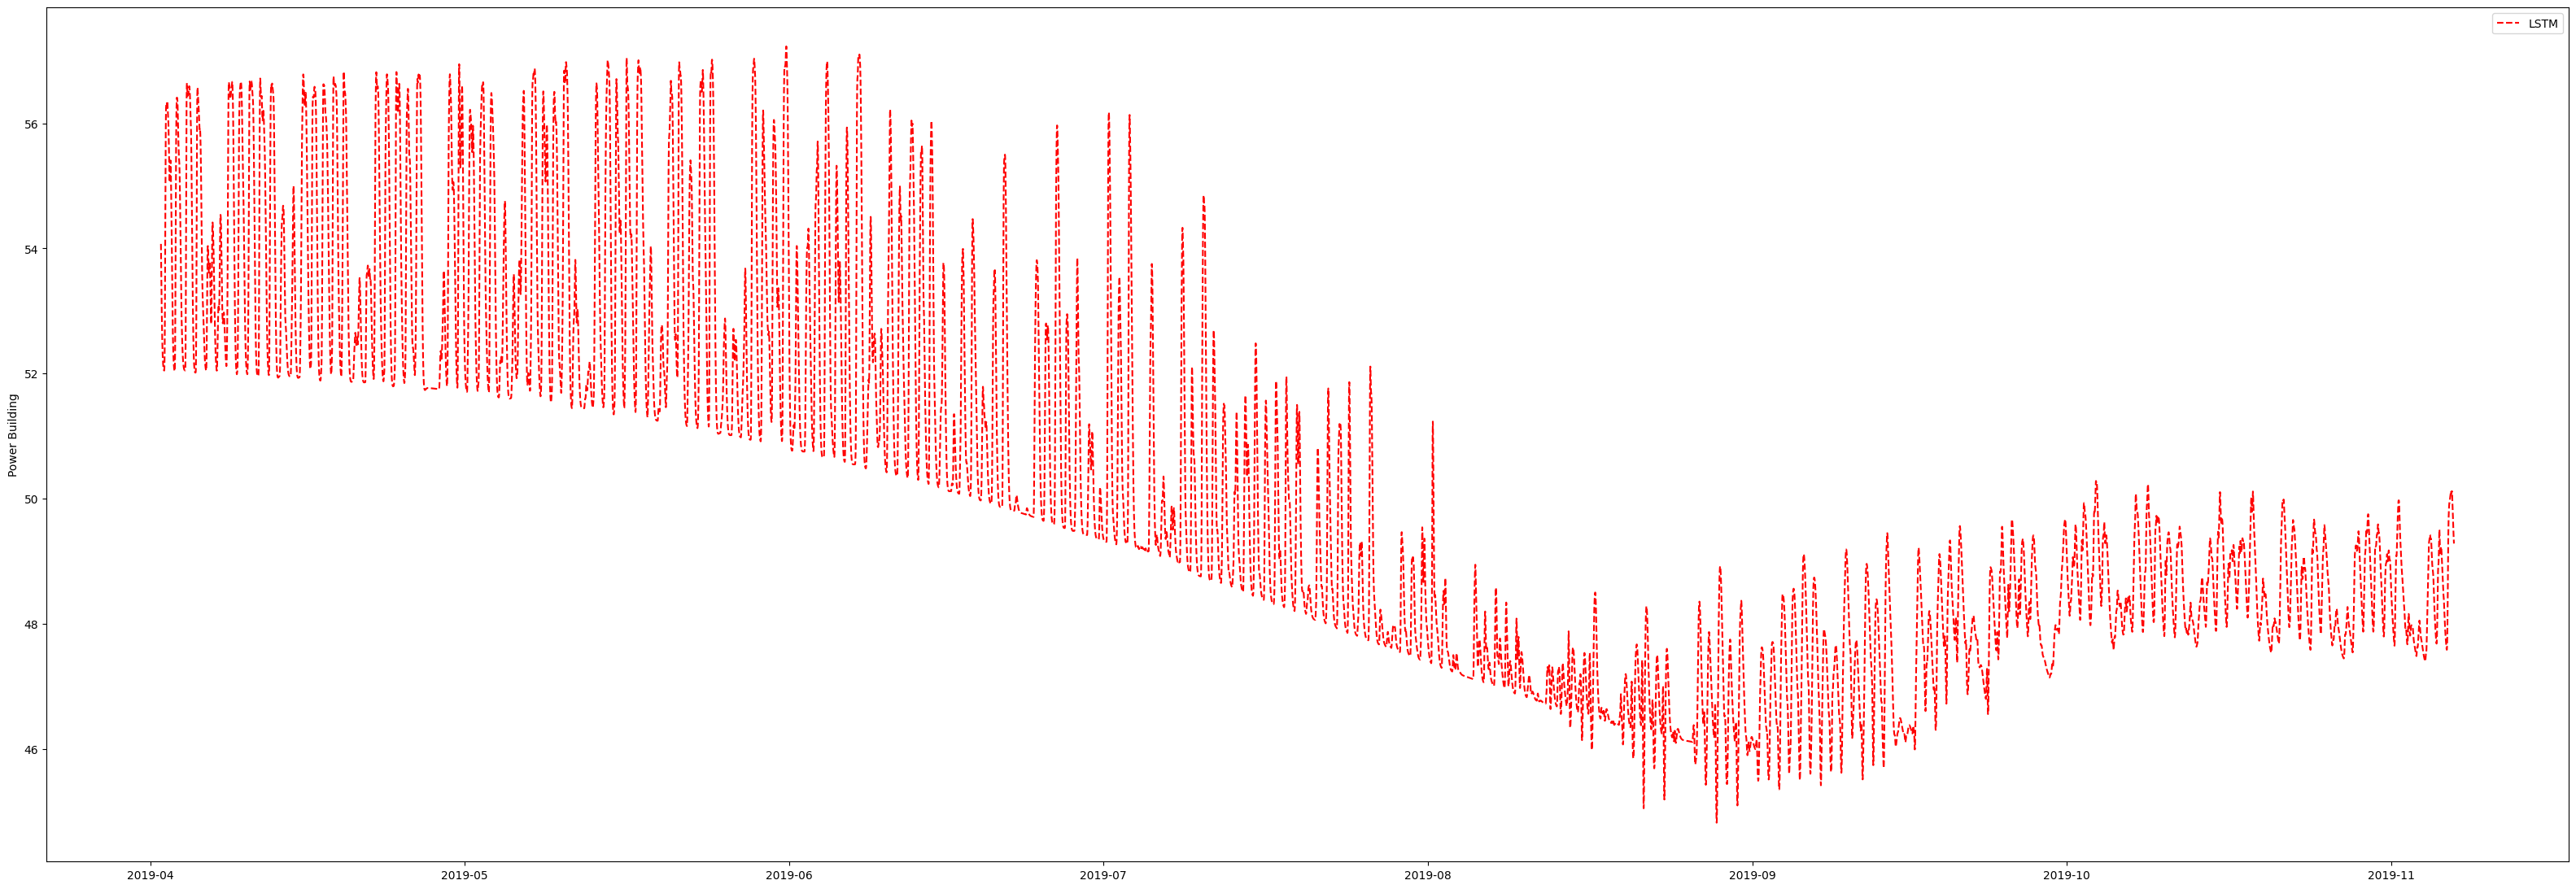

In [17]:
plt.figure(figsize=(40,30))
plt.subplot(2,1,1)
plt.plot(X_train["DateTime"][window:], Yu, "r--", label="LSTM")
plt.ylabel("Power Building")
plt.legend()

**LSTM: Standardization of test data (-1,1)**

In [18]:
s3=MinMaxScaler(feature_range=(-1,1))

Xts=s3.fit_transform(X_test[["Timestamp", "EV_Power"]])

s4=MinMaxScaler(feature_range=(-1,1))
Yts=s4.fit_transform(Y_test[["RealPower"]])

In [19]:
Yti=[]
Xti=[]

for i in range(window, len (Xts)):
    Xti.append(Xts[i-window:i,:])
    Yti.append(Yts[i])

Xti,Yti=np.array(Xti), np.array(Yti)

**LSTM: Testing with new data**

In [20]:
Ytp=model.predict(Xti)

Ytu=s2.inverse_transform(Ytp)
Ytm=s2.inverse_transform(Yti)

163/163 [==============================] - 9s 41ms/step


*PLot*

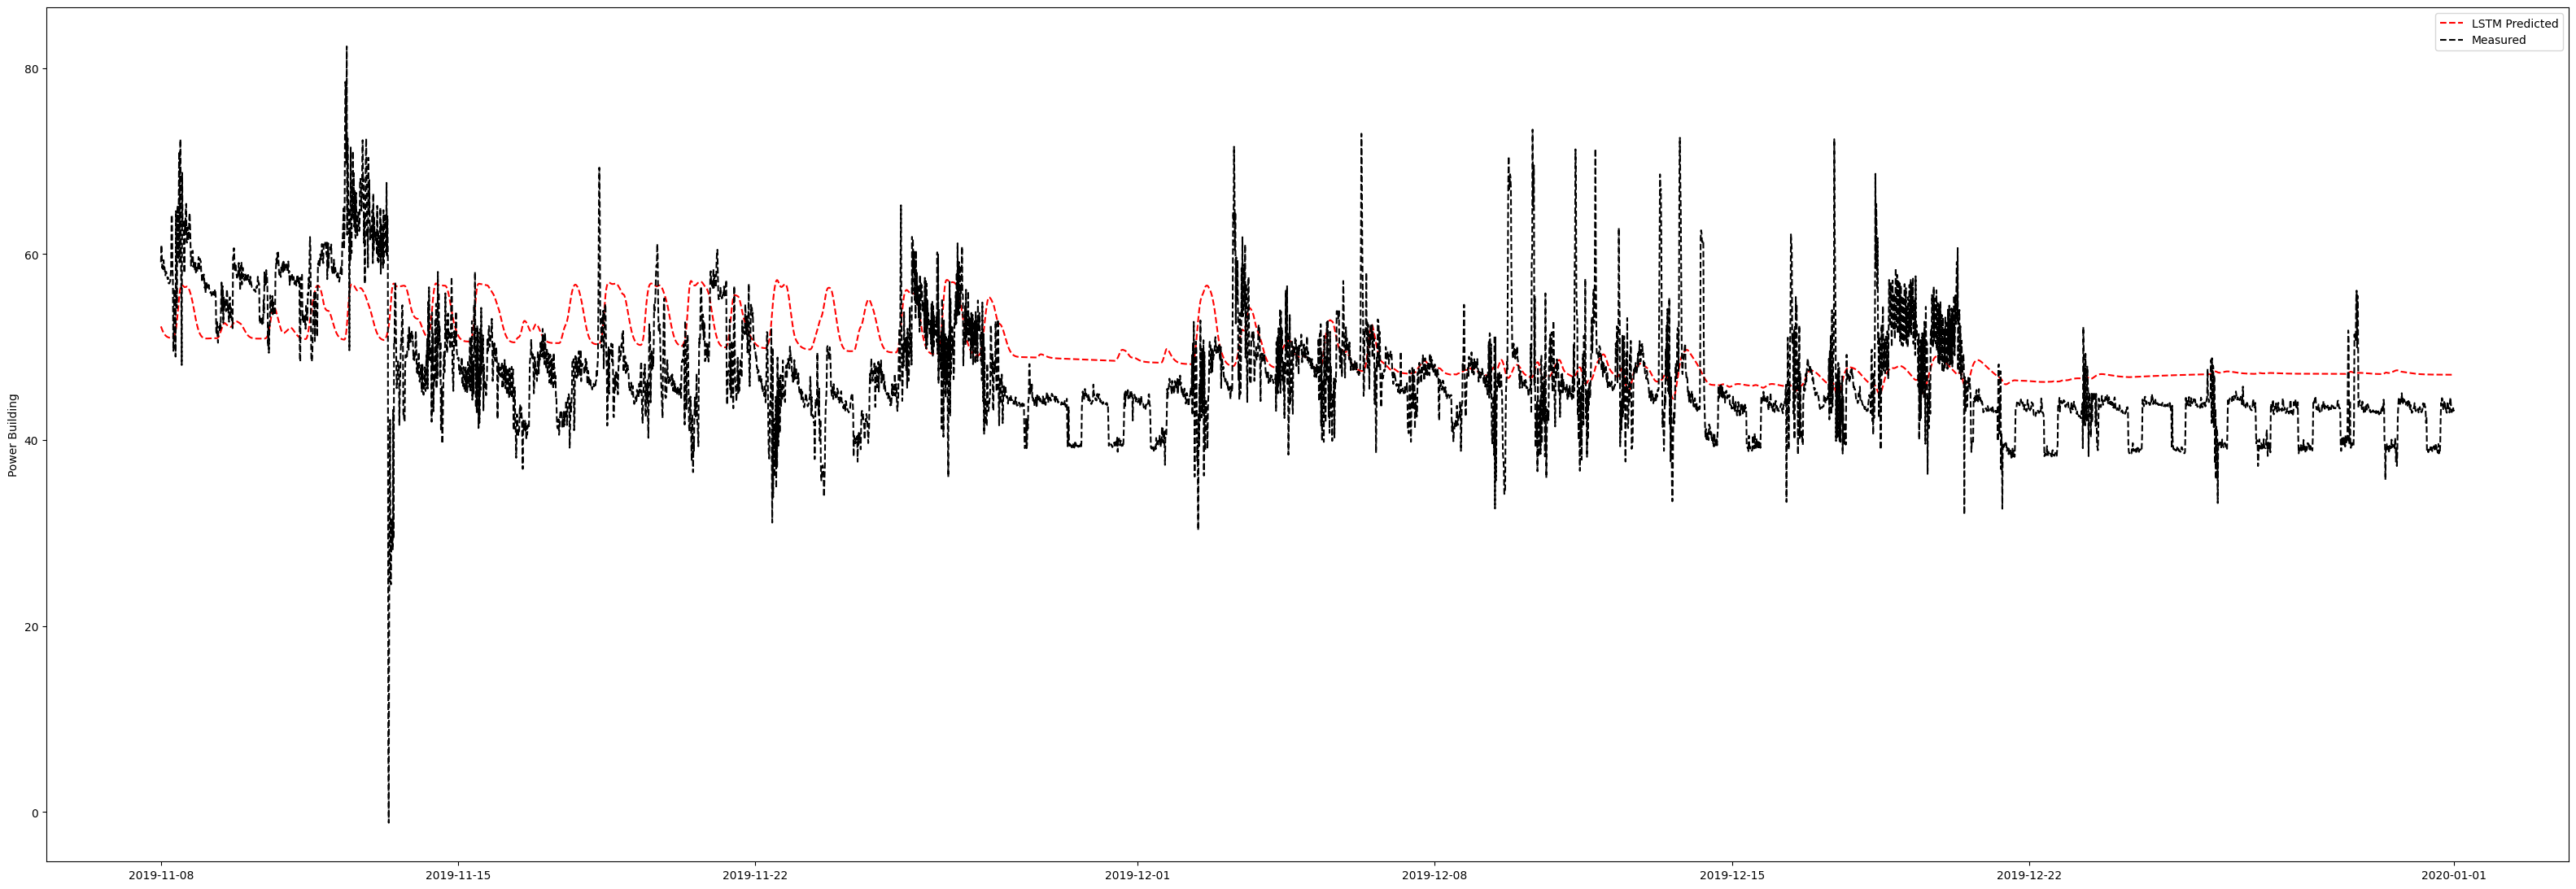

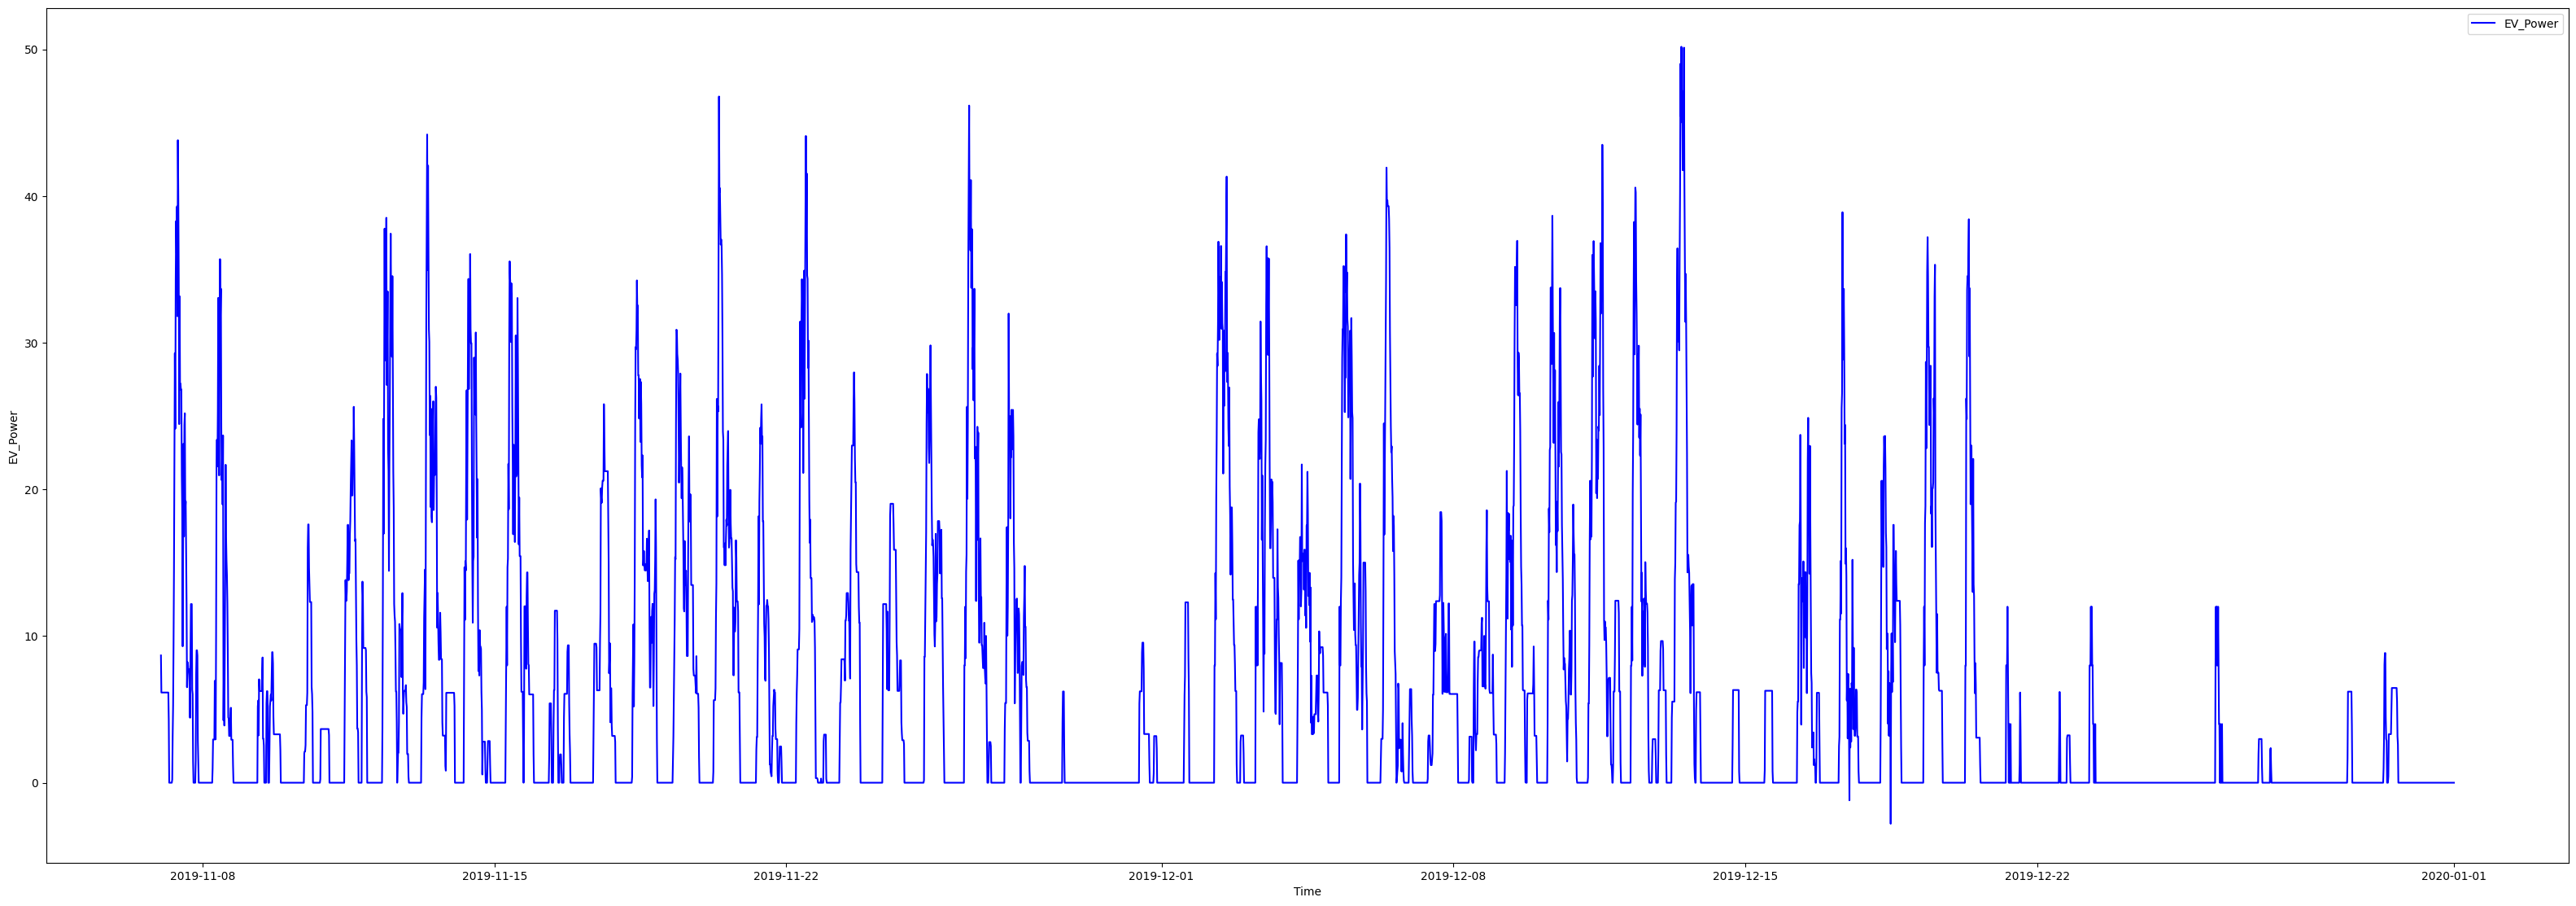

In [21]:
plt.figure(figsize=(40,30))
plt.subplot(2,1,1)
plt.plot(X_test["DateTime"][window:], Ytu, "r--", label="LSTM Predicted")
plt.plot(X_test["DateTime"][window:], Ytm, "k--", label="Measured")
plt.ylabel("Power Building")
plt.legend()

plt.figure(figsize=(40,30))
plt.subplot(2,1,1)
plt.plot(X_test["DateTime"], X_test["EV_Power"],"b-", label="EV_Power")
plt.xlabel("Time")
plt.ylabel("EV_Power")
plt.legend()


In [22]:
Y_test

RealPower
5280     46.021
5279     47.323
5278     47.225
5277     47.281
5276     47.209
...         ...
4        38.493
3        38.577
2        38.619
1        38.394
0        38.456

[5281 rows x 1 columns]

In [24]:
cont_Iguales = 0
cont_Diferentes = 0

for i in range(len(Xts)):
    X_eval = Xts[i:i+1]  # Esto selecciona una sola muestra de Xts

    # Asegúrate de que X_eval tenga la forma adecuada (batch_size, timesteps, features)
    # Si tu modelo espera más de una muestra, podrías necesitar ajustar esto
    X_eval = np.expand_dims(X_eval, axis=0)

    Y_eval = model.predict(X_eval)
    Y_true = Yts[i]

    Y_eval_unscaled = s2.inverse_transform(Y_eval)
    Y_true_unscaled = s4.inverse_transform(Y_true.reshape(1, -1))

    print("Modelo:", Y_eval_unscaled[0][0])
    print("Real:  ", Y_true_unscaled[0][0])

    diff = abs(Y_eval_unscaled - Y_true_unscaled)[0][0]  # Accede al valor real de la diferencia
    print("Diferencia:", diff)

    if diff <= 2.5:
        cont_Iguales += 1
        print("Iguales")
    else:
        cont_Diferentes += 1
        print("Diferentes")

ratio = np.round(cont_Iguales / (cont_Iguales + cont_Diferentes) * 100, 0)
print("Iguales:", cont_Iguales, "registros")
print("Diferentes:", cont_Diferentes, "registros")
print("Porcentaje:", ratio, "%")


1/1 [==============================] - 0s 40ms/step
Modelo: 45.06485
Real:   46.021
Diferencia: 0.9561501464843758
Iguales
1/1 [==============================] - 0s 69ms/step
Modelo: 45.0568
Real:   47.323
Diferencia: 2.266199157714844
Iguales
1/1 [==============================] - 0s 40ms/step
Modelo: 45.05679
Real:   47.225
Diferencia: 2.168210601806642
Iguales
1/1 [==============================] - 0s 28ms/step
Modelo: 45.056774
Real:   47.281
Diferencia: 2.224225860595702
Iguales
1/1 [==============================] - 0s 59ms/step
Modelo: 45.05676
Real:   47.209
Diferencia: 2.152241119384769
Iguales
1/1 [==============================] - 0s 50ms/step
Modelo: 45.056747
Real:   47.113
Diferencia: 2.056252563476562
Iguales
1/1 [==============================] - 0s 77ms/step
Modelo: 45.056736
Real:   46.56
Diferencia: 1.5032640075683616
Iguales
1/1 [==============================] - 0s 37ms/step
Modelo: 45.05672
Real:   47.097
Diferencia: 2.040279266357423
Iguales
1/1 [================

**Using predicted values to predict next step**

the initial model is loaded and used to make predictions on the test data, but the input data (Xtsq) is also updated at each iteration based on the previous prediction, implying a "recursive prediction" or "on-line prediction" approach.

In [25]:
Xtsq=Xts.copy()

v=load_model("model")

for i in range(window, len(Xtsq)):
    Xin=Xtsq[i-window:i].reshape(1,window,2)
    prediction = v.predict(Xin)
    Xtsq[i][0] = prediction[0][0] 
    Yti[i-window]=Xtsq[i][0]


Ytu=s2.inverse_transform(Yti)



1/1 [==============================] - 0s 54ms/step


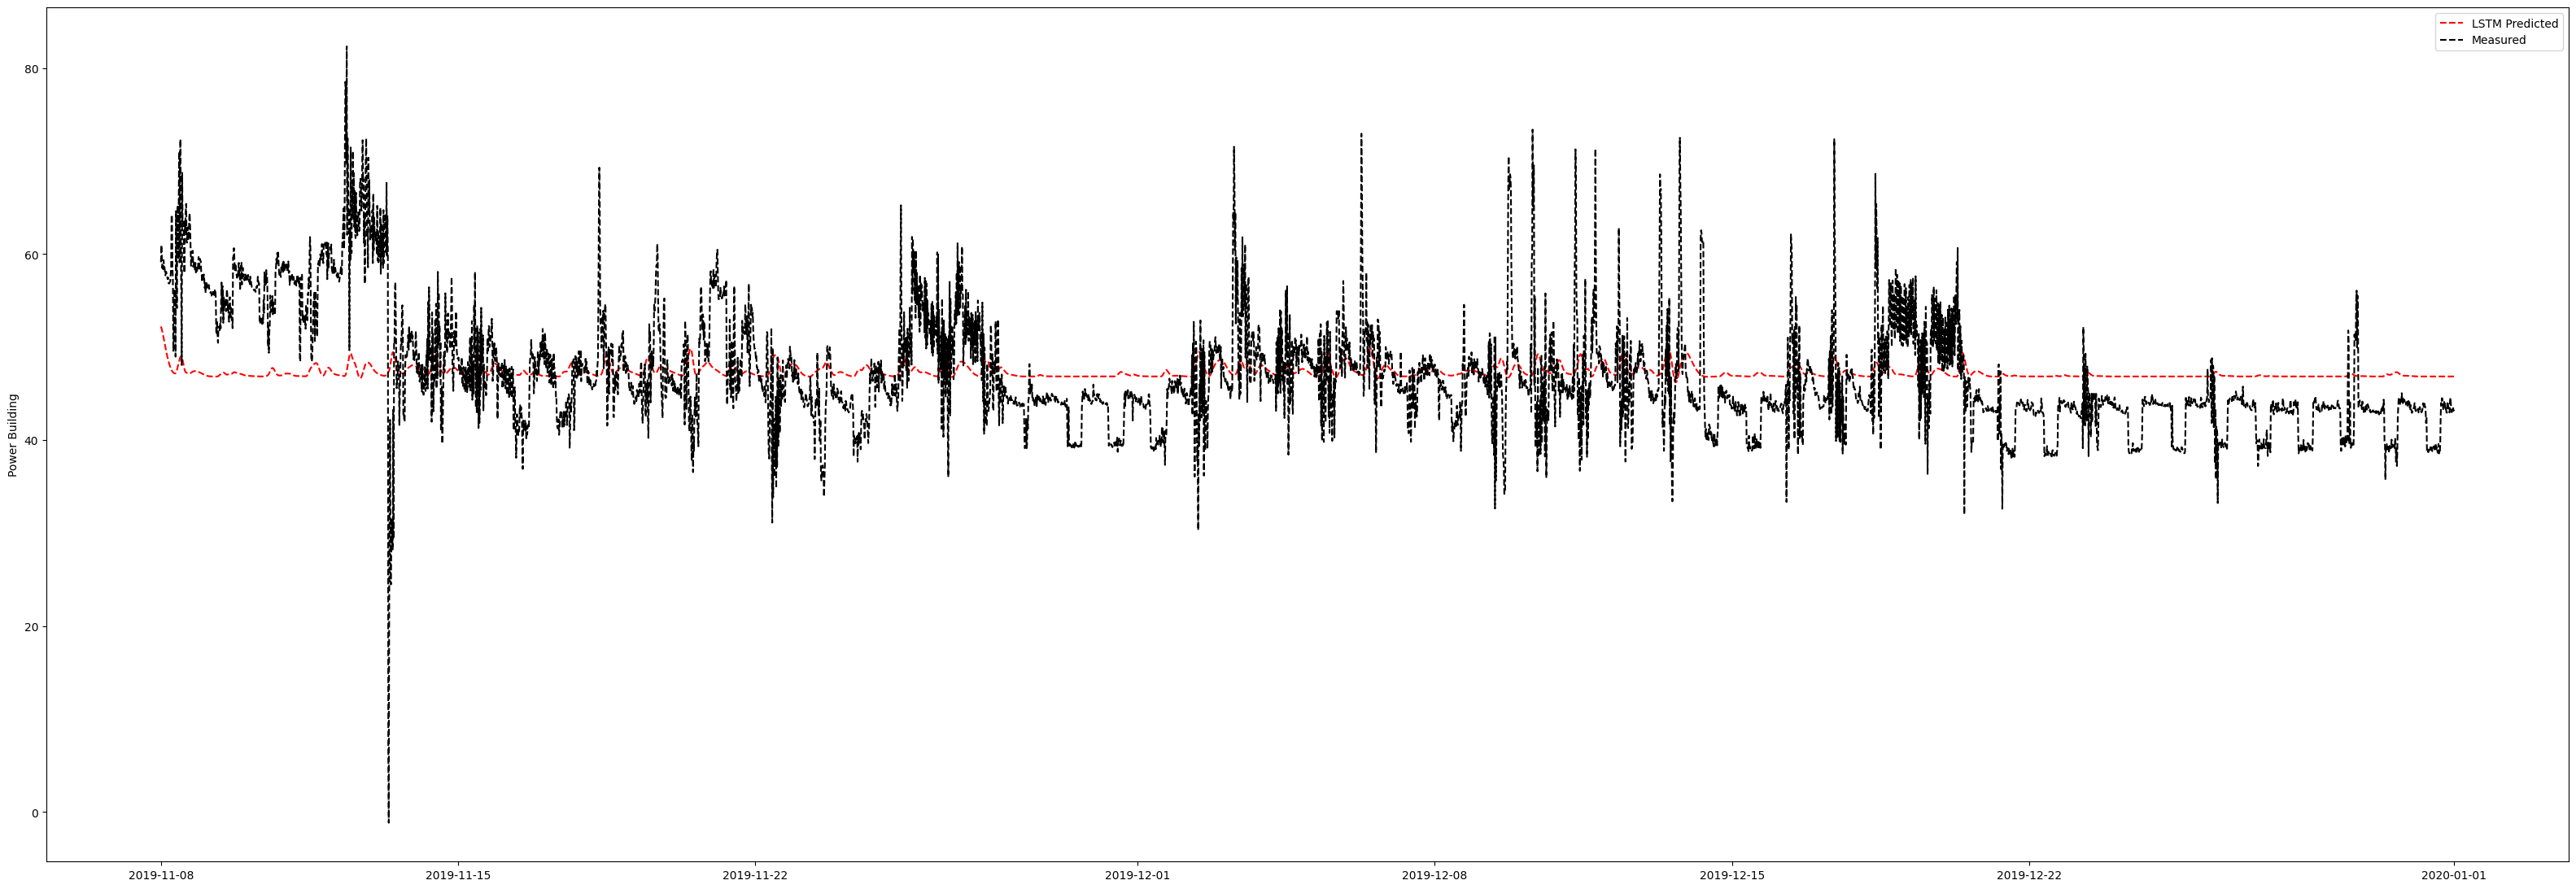

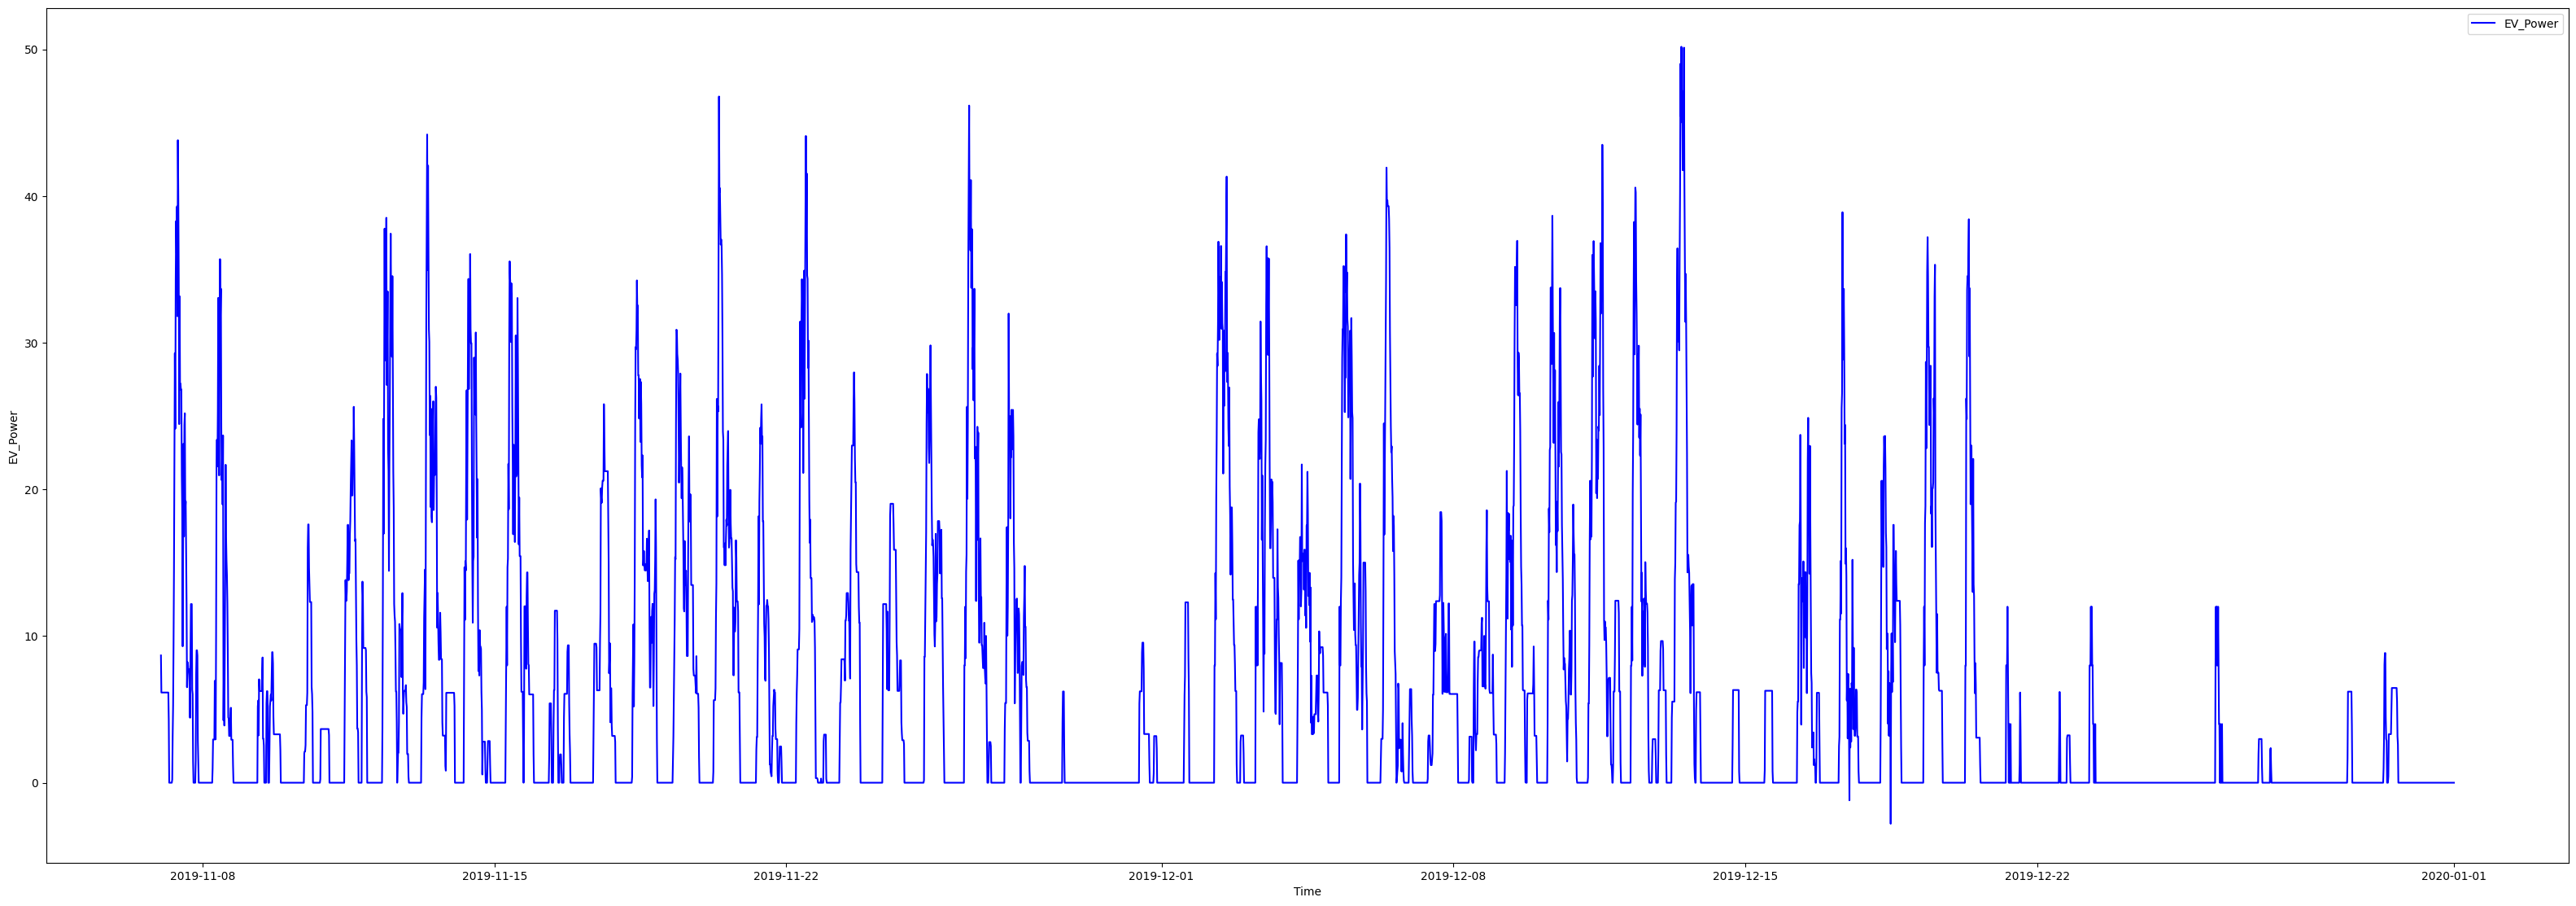

In [26]:
plt.figure(figsize=(40,30))
plt.subplot(2,1,1)
plt.plot(X_test["DateTime"][window:], Ytu, "r--", label="LSTM Predicted")
plt.plot(X_test["DateTime"][window:], Ytm, "k--", label="Measured")
plt.ylabel("Power Building")
plt.legend()

plt.figure(figsize=(40,30))
plt.subplot(2,1,1)
plt.plot(X_test["DateTime"], X_test["EV_Power"],"b-", label="EV_Power")
plt.xlabel("Time")
plt.ylabel("EV_Power")
plt.legend()